In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
from load_data import load_data
import torch
from utils import get_all_walks, plot_mutagenicity
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
graphs, pos_idx, neg_idx = load_data('Mutagenicity')
nn = torch.load("models/gin-3-mutagenicity.torch")

num_graphs: 4337


In [3]:
idx = 22
order = 3


model_depth = len(nn.blocks)-1
gammas = np.linspace(3,0,model_depth)

g = graphs[idx]
node_candidates = np.arange(g.nbnodes)
shape = (len(node_candidates),)*(model_depth +1)
rel_tensor = torch.zeros(*shape)
walks = get_all_walks(2, g.get_adj())

label is 0
order:  3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FileNotFoundError: [Errno 2] No such file or directory: 'imgs/mol_mut_lohohist.svg'

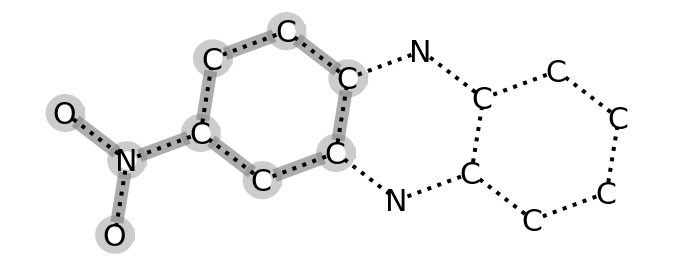

In [4]:
subgraph = [0,1,3,5,7,9,11,14,15]
    
print('label is', g.label)
print('order: ', order)
sub_relevances = []
for walk in walks:
    a,b= walk
    if a in subgraph and b in subgraph:
        sub_relevances.append([walk, .4 ])
        pass

plot_mutagenicity(g,sub_relevances,factor=1,figname='imgs/mol_mut_lohohist.svg',color='grey')

### Analyzing the distribution of subgraph relevances when considering different attribution orders

In [5]:
import subgraph_relevance as sr
from itertools import combinations
node_label_dict = {0:'C',1:'O',2:'Cl',3:'H',4:'N',5:'F',6:'Br',7:'S',8:'P',9:'I',10:'Na',11:'K',12:'Li',13:'Ca'}
sample_ids = range(2000) 
#######

all_subfgs = []
atoms = ['C', 'N','O']
for size in range(1,len(atoms)+1): all_subfgs += list(combinations(atoms, size))
model_depth = len(nn.blocks)-1

gammas = list(np.linspace(3, 0, model_depth))

lo_rels = {}
ho_rels = {}
for subgraph_by_atoms in tqdm(all_subfgs):
    los, hos = [], []
    for idx in sample_ids:
        g = graphs[idx]
        node_candidates = np.arange(g.nbnodes)
        # shape = (len(node_candidates),)*(model_depth +1)
        atom_numb_list = [node_label_dict[node_id] for node_id in g.node_tags]
        S = [idx for idx in node_candidates if atom_numb_list[idx] in subgraph_by_atoms]

        ho_subrel = sr.subgraph_mp_forward_hook(nn, g, S, gamma=gammas)
        lo_subrel = nn.lrp(g.adj,gammas,g.label,None,H0=g.node_features)[S].sum()
        los.append(lo_subrel.numpy()); hos.append(ho_subrel.numpy())
        
    ho_rels[subgraph_by_atoms] = np.array(hos)
    lo_rels[subgraph_by_atoms] = np.array(los)

100%|██████████| 7/7 [01:27<00:00, 12.47s/it]


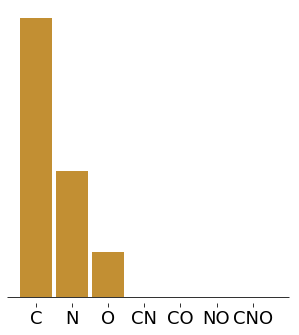

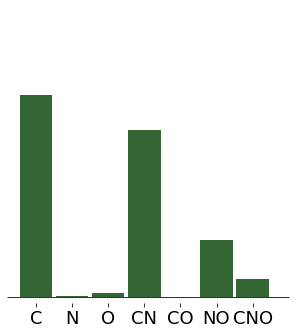

In [7]:
from functools import reduce
import matplotlib.patches as mpatches

subfgs = all_subfgs #[7:14]
samples = [22]
cmap = plt.get_cmap('viridis')

def interaction_rel(fg, rels, only_atoms=False):
    if len(fg) == 1: 
        return rels[fg]
    if len(fg) == 2: 
        first_order_fgs = [(at,) for at in fg]
        outrel = rels[fg].copy()
        for subst_fg in first_order_fgs: 
            outrel -= rels[subst_fg]
        return outrel
    if len(fg) == 3:
        first_order_fgs = [(at,) for at in fg]
        second_order_fgs = list(combinations(list(fg), 2)) 
        
        outrel = rels[fg].copy()
        for subst_fg in first_order_fgs: 
            outrel += rels[subst_fg]
        
        for subst_fg in second_order_fgs: 
            outrel -= rels[subst_fg]
            
        return outrel

for order,rels in zip(['lo','ho'],[lo_rels,ho_rels]):
    plt.figure(figsize=(4.5,5))
    plt.rcParams.update({'font.size': 18})
    ax = plt.subplot(1,1,1)
    names = []
    xs=range(len(subfgs))
    color_patches=[]
    
    for fg,color,x in zip(subfgs, torch.linspace(0,1,len(subfgs)), xs):
        name = reduce(lambda a,b: a+b, fg)
        names.append(name)
        if order == 'lo':
            color=(0.7,.45,.0,1)
        else:
            color=(0.,.25,.0,.9)

        hirel= interaction_rel(fg,rels,only_atoms=True)[samples].mean()
        if np.isclose(hirel,0,atol=1e-05):
            pass
        else:
            ax.bar(x, 
                   hirel,
                   alpha=0.8, 
                   color=color,
                  align='center',
                  width=0.9)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xlim(-.8,len(subfgs)+.1)

    ax.set_xticks(list(xs))
    ax.set_xticklabels(names)
    ax.set_yticks([])
    ax.hlines(0, -.8, len(subfgs), color='black', lw=.8)

    color_patches.append(mpatches.Patch(color=(0.,.5,.0,1), label='higher-order'))
    color_patches.append(mpatches.Patch(color=(0.9,.65,.0,1), label='lower-order'))


    ax.set_ylim(-0.1,5.2)

    plt.tight_layout()
    plt.savefig(f'imgs/histogram_{order}_mol.png',transparent=True)
    plt.show()
    plt.close()

### higher and lower order heat maps of mutagenic submolecules

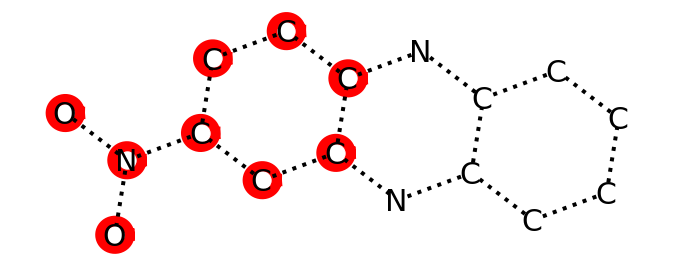

In [8]:
all_subfgs = []

subgraph1 = tuple([0,1,3,5,7,9])
subgraph2 = tuple([11,14,15])
subgraph3 = tuple([2,4,6,8,10,12,13,16])

fgs = subgraph1+ subgraph2

order = 1

idx = 22

model_depth = len(nn.blocks)-1
gammas = np.linspace(3,0,model_depth)
g = graphs[idx]
node_candidates = np.arange(g.nbnodes)
shape = (len(node_candidates),)*(model_depth +1)
rel_tensor = torch.zeros(*shape)

walks = get_all_walks(model_depth+1, g.adj)

for walk in walks:
    full_relevances = []
    rel = nn.lrp(g.get_adj(),gammas,g.label,walk,H0=g.node_features).sum()
    full_relevances.append([walk, rel.numpy()])
    rel_tensor[tuple(walk)] = rel


sub_tensor = rel_tensor.clone()
for _ in range((model_depth + 1) - order) : sub_tensor = sub_tensor.sum(-1)

sub_relevances = []
for walk in get_all_walks(order, g.get_adj()):

    index = tuple(set(walk)) if order==1 else tuple(walk)
    node_tags = [g.node_tags[node_id] for node_id in walk]
    if all([node in fgs for node in walk]):# and len(tuple(set(node_tags))) >1 :
        sub_relevances.append([walk, sub_tensor[index].numpy()])

plot_mutagenicity(g,sub_relevances,factor=1,figname='imgs/low_order_mutag_mol.svg')